<a href="https://colab.research.google.com/github/paladin99/GNN-molecular-classification/blob/main/GNNPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[DEEP LEARNING MODEL TO PREDICT AQUEOUS SOLUBILITY OF ORGANIC MOLECULES](https://arxiv.org/pdf/2105.12638.pdf)**

 DATASET USED: CURATED SOLUBILITY DATASET
 

In [1]:
!pip install rdkit-pypi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
import networkx as nx
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw

# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
soldata = pd.read_csv(
    "https://raw.githubusercontent.com/paladin99/GNN-molecular-classification/main/curated-solubility-dataset.csv"
)
np.random.seed(0)


In [2]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
       nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [3]:
nodes, adj = gen_smiles2graph("CO")
nodes

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [4]:
nodes, adj = gen_smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[6., 3., 2., 2., 2., 2.],
       [5., 4., 2., 2., 2., 2.],
       [5., 3., 3., 2., 2., 2.],
       [5., 3., 2., 3., 2., 2.],
       [5., 3., 2., 2., 3., 2.],
       [5., 3., 2., 2., 2., 3.]])

In [5]:
degree = np.sum(adj_mat, axis=-1)
degree

array([17., 17., 17., 17., 17., 17.])

In [6]:
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0.         0.47058824 0.         0.         0.         0.
 0.35294118 0.         0.17647059 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [7]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

In [8]:
gcnlayer = GCNLayer("relu")
# we insert a batch axis here
gcnlayer((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))

(<tf.Tensor: shape=(1, 6, 100), dtype=float32, numpy=
 array([[[0.06194812, 0.04279358, 0.        , 0.15031138, 0.        ,
          0.13226089, 0.08745448, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.03914495, 0.01223842, 0.        ,
          0.01056614, 0.        , 0.        , 0.00529139, 0.        ,
          0.00019692, 0.        , 0.01825275, 0.        , 0.0202723 ,
          0.07580621, 0.07815593, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.07226635, 0.00582164, 0.        ,
          0.        , 0.        , 0.        , 0.04575825, 0.02676622,
          0.        , 0.0404998 , 0.04612844, 0.        , 0.04950807,
          0.01992454, 0.01826081, 0.03041207, 0.        , 0.04113808,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.14548223, 0.0870993 , 0.        , 0.        , 0.        ,
          0.05180654, 0.        , 0.        , 0.        , 0.04904281,
          0.0109478 , 0.02687643, 0.

In [9]:
x = (nodes[np.newaxis, ...], adj_mat[np.newaxis, ...])
for i in range(2):
    x = gcnlayer(x)
x

(<tf.Tensor: shape=(1, 6, 100), dtype=float32, numpy=
 array([[[8.57707171e-04, 2.18159724e-02, 1.02681518e-02, 6.28801510e-02,
          0.00000000e+00, 1.36465970e-02, 5.03206886e-02, 2.66904314e-03,
          0.00000000e+00, 0.00000000e+00, 3.98886204e-02, 0.00000000e+00,
          0.00000000e+00, 3.27293240e-02, 5.98209202e-02, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.11511900e-02,
          6.73516914e-02, 0.00000000e+00, 0.00000000e+00, 1.72258466e-02,
          4.63750623e-02, 0.00000000e+00, 2.03309171e-02, 0.00000000e+00,
          3.75284888e-02, 7.57290050e-02, 0.00000000e+00, 0.00000000e+00,
          1.24767097e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.73276085e-02, 2.84232479e-02, 9.82087776e-02, 0.00000000e+00,
          7.81670213e-03, 0.00000000e+00, 6.72904134e-05, 7.68625513e-02,
          0.00000000e+00, 1.38630327e-02, 0.00000000e+00, 1.87098533e-02,
          0.00000000e+00, 2.45265756e-02, 0.00000000e+00, 

In [10]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [11]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

In [12]:
nodes, adj = gen_smiles2graph("CO")
model((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01869116]], dtype=float32)>

In [13]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

In [14]:
test_data = data.take(400)
val_data = data.skip(400).take(200)
train_data = data.skip(600)

In [23]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(
    train_data.batch(1), validation_data=val_data.batch(1), epochs=20, verbose=0
)

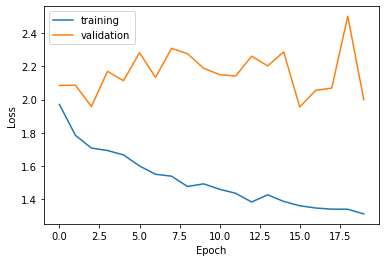

In [24]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()